## Final Project: DS-SEA-4
**Jenna White  **
  
**Question:**  
Can I use past behavior on the Rover.com site to identify people who should be prioritized for diversion investigations?  
  
**Data:**  
3105 observations of conversations flagged for inspection by our diversion team based on message composition. I will be seeing if I can create a model that will predict diversion based on the participant data, so that we can better prioritize these conversations when they hit our queue.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = '/Users/jennawhite/Documents/gaclass/wild_west/Rover_Diversion/data_1126.csv'
data = pd.read_csv(url)

In [4]:
data.shape

(3105, 56)

### Data Pre-Processing

In [6]:
data.years_of_experience.mean() #13.1875
data.years_of_experience.fillna(13.0, inplace=True)

In [7]:
#not everyone has notes from our customer-facing teams, I've replaced N/As with 'none' so that I can do text processing
data.staff_notes.fillna('none',inplace=True)
data.owner_staff_notes.fillna('none',inplace=True)

In [8]:
data.voice_calls.fillna(0, inplace=True)
data.calls_duration.fillna(0, inplace=True)

In [9]:
# create a feature 'mg_code' that indicates if no meet&greet was planned - 0 -,
# one was planned and didnt happen -1- or did happen -2-
data['happened'].fillna(3, inplace='True')
data['mg_code'] = data.happened.map({3.0:0,0.0:1,1.0:2})

In [10]:
# there is a huge weight towards female sitters - so what I have done is create a feature called 'is_female'
# I map gender 'unknowns' and 'male' to 0
data.gender.fillna('u', inplace=True)
data['is_female'] = data.gender.map({'u':0,'m':0,'f':1})

In [11]:
#categorizes service as overnight or not...
data['overnight']=data.service_type.map({'dog-walking':0,'doggy-day-care':0,'drop-in':0,'overnight-boarding':1,'overnight-traveling':1})

In [12]:
#...plus has the exact service as a get_dummies
data = pd.concat([data,pd.get_dummies(data['service_type'],prefix='svc')],axis=1)

In [13]:
#resulting data set
data.head()

,conversation_id,diversion_tickets,first_diversion_ticket,last_diversion_ticket,trigger_content_type_id,is_diverting,id,requester_id,provider_id,convo_added,...,voice_calls,calls_duration,mg_code,is_female,overnight,svc_dog-walking,svc_doggy-day-care,svc_drop-in,svc_overnight-boarding,svc_overnight-traveling
0,3370262,1,11/17/16,11/17/16,36,0,3370262,1398797,1805568,10/28/16,...,1.0,12.0,2,1,1,0.0,0.0,0.0,0.0,1.0
1,3286711,1,11/7/16,11/7/16,36,1,3286711,410655,1976198,10/17/16,...,0.0,0.0,2,1,1,0.0,0.0,0.0,1.0,0.0
2,3487906,1,11/15/16,11/15/16,36,0,3487906,2120281,1846925,11/13/16,...,0.0,0.0,2,0,0,1.0,0.0,0.0,0.0,0.0
3,3345971,1,11/9/16,11/9/16,36,0,3345971,2054553,938077,10/25/16,...,0.0,0.0,2,1,1,0.0,0.0,0.0,1.0,0.0
4,3324566,1,11/9/16,11/9/16,36,0,3324566,2044012,1711700,10/22/16,...,0.0,0.0,2,1,0,0.0,0.0,1.0,0.0,0.0


In [14]:
data.columns

Index([u'conversation_id', u'diversion_tickets', u'first_diversion_ticket',
       u'last_diversion_ticket', u'trigger_content_type_id', u'is_diverting',
       u'id', u'requester_id', u'provider_id', u'convo_added', u'start_date',
       u'days_til_start', u'service_type', u'provider_first_response_minutes',
       u'has_stay', u'is_repeat_customer', u'source', u'provider_group_id',
       u'need_id', u'requester_was_new_customer', u'years_of_experience',
       u'posted_on_craigslist', u'match_date', u'approved_on',
       u'sitter_user_id', u'sitter_account_added', u'dog_history', u'active',
       u'gender', u'birth_year', u'email_verified', u'ratings_average',
       u'ratings_count', u'testimonial_count', u'profile_quality',
       u'response_percent', u'response_time', u'marketing_partner',
       u'stay_images_global_opt_out', u'staff_notes', u'does_not_have_dogs',
       u'owner_user_id', u'owner_account_added', u'owner_active',
       u'owner_gender', u'owner_birth_year', u'o

## Feature Selection
### Profile Data

In my Data Exploration notebook, I went through many of the columns above to see if there was any correlation between the response variable (is_diverting) and the selected feature. Here are a few that showed some promise:

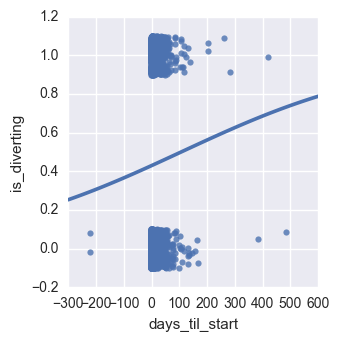

In [28]:
sns.lmplot(x='days_til_start', y='is_diverting', data=data, size=3.5, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

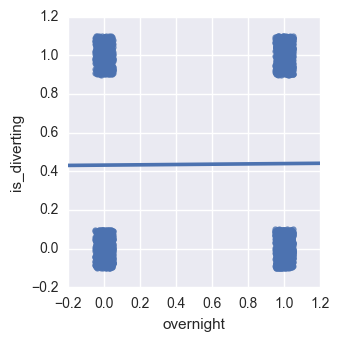

In [31]:
#by overnight or day-time, there doesn't seem to be a bias towards diverting...
sns.lmplot(x='overnight', y='is_diverting', data=data, size=3.5, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

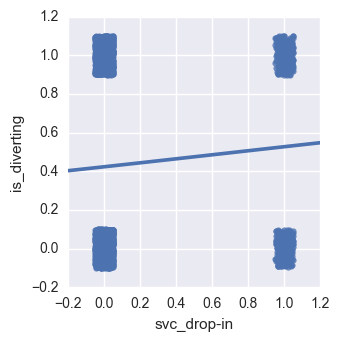

In [32]:
# ...BUT drop-in had a much stronger correlation than other services
sns.lmplot(x='svc_drop-in', y='is_diverting', data=data, size=3.5, ci=None, logistic=True, x_jitter=0.05, y_jitter=0.1)

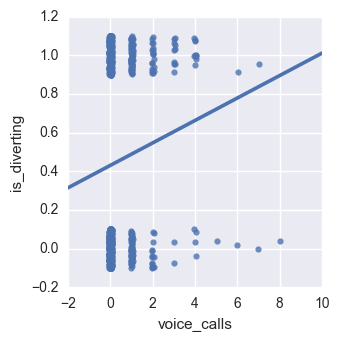

In [25]:
sns.lmplot(x='voice_calls', y='is_diverting', data=data, size=3.5, ci=None, x_jitter=0.05, y_jitter=0.1)

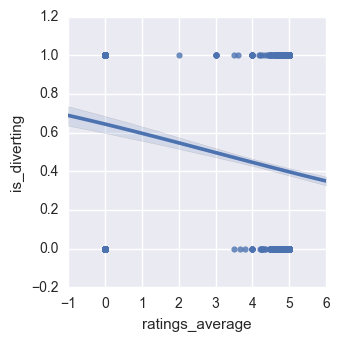

In [26]:
sns.lmplot(x='ratings_average', y='is_diverting', data=data, size=3.5, logistic=True)

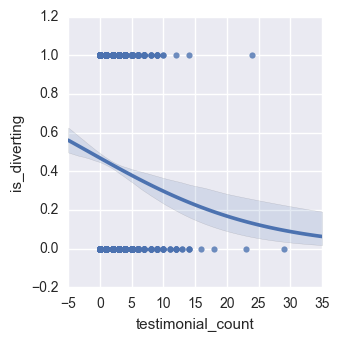

In [29]:
sns.lmplot(x='testimonial_count', y='is_diverting', data=data, size=3.5, logistic=True)

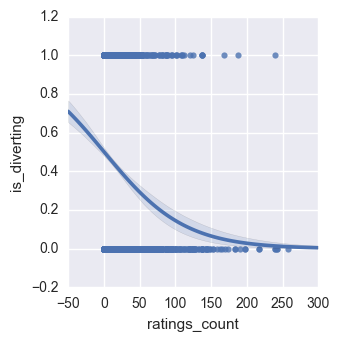

In [30]:
sns.lmplot(x='ratings_count', y='is_diverting', data=data, size=3.5, logistic=True)

Using the outputs from these, and other, exploratory charts, I created a test feature set for behavioral and profile data:

In [199]:
test_columns = [
                'days_til_start',
                'years_of_experience',
                'ratings_average',
                'ratings_count',
                'testimonial_count',
                'calls_duration',
                'voice_calls',
               'svc_drop-in',
               ]


## Staff_Notes


Another important column in this dataset is "staff_notes" -- this refers to unstructured notes written by our customer-facing teams. They can be negative, positive, or just an internal note. To parse these, I used TD-IDF.

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

In [56]:
print 'No Owner Staff Notes for', len(data[data['owner_staff_notes']=='none']),'conversations (97.7%).'
print 'No Sitter Staff Notes for', len(data[data['staff_notes']=='none']),'conversations (78.8%).'


No Owner Staff Notes for 3035 conversations (97.7%).
No Sitter Staff Notes for 2446 conversations (78.8%).


Because of the above, I decided to just parse Sitter staff notes.

In [82]:
text_columns = ['staff_notes','is_diverting']
datav = data[text_columns]
datav = datav[datav['is_diverting']==1]

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction import text


notes = datav.staff_notes

vectorizer2 = TfidfVectorizer(stop_words='english', max_features=250, decode_error='ignore', ngram_range=(1, 2))

In [180]:
X = vectorizer2.fit_transform(notes)
indices = np.argsort(vectorizer2.idf_)[:-1:]
features = vectorizer2.get_feature_names()
top_n = 15
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'sitter', u'16', u'dog', u'2016', u'11', u'10', u'owner', u'stay', u'dogs', u'rover', u'qa', u'rg', u'11 16', u'home', u'rover dog']


**Above are the features that are the most common in staff_notes of sitters who have been confirmed diverters.**  

**I then wanted to see if there were any clear outliers in notes of diverters vs the most common words in the notes of non-diverters**

In [276]:
datavx = data[data['is_diverting']==0]

notes2 = datavx.staff_notes
vectorizer2 = TfidfVectorizer(stop_words='english', max_features=5000, decode_error='ignore', ngram_range=(1, 2))

In [277]:
X2 = vectorizer2.fit_transform(notes2)
indices2 = np.argsort(vectorizer2.idf_)[:-1:]
features2 = vectorizer2.get_feature_names()
top_n = 15
top_features2 = [features2[i] for i in indices2[:top_n]]
print top_features2

[u'sitter', u'16', u'dog', u'2016', u'owner', u'rover', u'10', u'stay', u'11', u'rover dog', u'dogs', u'rd', u'coached', u'vet', u'care']


In [278]:
top_features # for diverters


[u'sitter',
 u'16',
 u'dog',
 u'2016',
 u'11',
 u'10',
 u'owner',
 u'stay',
 u'dogs',
 u'rover',
 u'qa',
 u'rg',
 u'11 16',
 u'home',
 u'rover dog']

In [279]:
top_features2 #non-diverters

[u'sitter',
 u'16',
 u'dog',
 u'2016',
 u'owner',
 u'rover',
 u'10',
 u'stay',
 u'11',
 u'rover dog',
 u'dogs',
 u'rd',
 u'coached',
 u'vet',
 u'care']

Actually the top appearing list for diverters and non-diverters are very similar - rg and qa are a bit higher up in the diverter list, but if you expand the feature cut-off, they appear pretty soon in the list. So instead of pulling out only a few features, I'm going to use the whole dictionary of 5000 features and evaluate it using a random forest


## Tuning the Model
### Profile Stats

In [349]:
Xdt = data[test_columns]
ydt = data.is_diverting

## use a random forest to see what test columns are most predictive
from sklearn.tree import DecisionTreeClassifier
max_depth_range = range(1, 10)
scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores = cross_val_score(treeclf, Xdt, ydt, cv=10, scoring='accuracy')
    scores.append(np.mean(accuracy_scores))

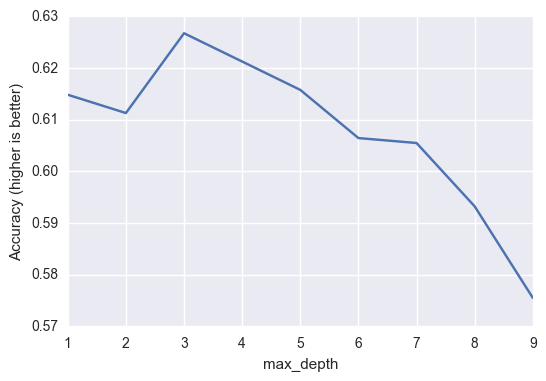

In [350]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy (higher is better)')

In [351]:
sorted(zip(scores, max_depth_range))


[(0.57551840860349324, 9),
 (0.59322098279697455, 8),
 (0.60548226643961589, 7),
 (0.60643855177573935, 6),
 (0.61128355872254059, 2),
 (0.61482053621450194, 1),
 (0.61576223310034117, 5),
 (0.62125033357736936, 4),
 (0.6267259267912223, 3)]

In [352]:
treeclf = DecisionTreeClassifier(max_depth = 3, random_state=1)
treeclf.fit(Xdt, ydt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [353]:
pd.DataFrame({'feature':test_columns, 'importance':treeclf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
3,ratings_count,0.733448
2,ratings_average,0.123748
0,days_til_start,0.111899
1,years_of_experience,0.030906
4,testimonial_count,0.000000
5,calls_duration,0.000000
6,voice_calls,0.000000
7,svc_drop-in,0.000000


In [354]:
from sklearn.cross_validation import cross_val_score
score = np.mean(cross_val_score(treeclf, Xdt, ydt, cv=10, scoring='accuracy'))
print score

0.626725926791


**The data I will be using in the model is 'ratings_count', 'ratings_average', and 'days_til_start'**

In [269]:
X = data.staff_notes
y = data.is_diverting


from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,y,random_state=1)


vect_x = TfidfVectorizer(stop_words='english', max_features=4000, decode_error='ignore', ngram_range=(1, 2))

In [270]:
xtrain_dtm=vect_x.fit_transform(xtrain)
xtest_dtm = vect_x.transform(xtest)
print xtrain_dtm.shape
print xtest_dtm.shape

(2328, 4000)
(777, 4000)


In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

log_reg = LogisticRegression(C=1.0)
log_reg.fit(xtrain_dtm, ytrain)
y_pred_class = log_reg.predict(xtest_dtm)

In [272]:
print metrics.accuracy_score(ytest,y_pred_class)

0.574002574003


In [323]:
step = np.arange(0.5,5,0.5)
for c in step:
    log_reg = LogisticRegression(C=c).fit(xtrain_dtm, ytrain)
    print "C= ", c, "  Accuracy: ", round(100 * log_reg.score(xtest_dtm, ytest),2)

# C=1.0 is the most tuned
    

C=  0.5   Accuracy:  57.01
C=  1.0   Accuracy:  57.4
C=  1.5   Accuracy:  57.01
C=  2.0   Accuracy:  56.76
C=  2.5   Accuracy:  57.01
C=  3.0   Accuracy:  56.89
C=  3.5   Accuracy:  56.76
C=  4.0   Accuracy:  56.76
C=  4.5   Accuracy:  56.76


### Random Forest OOB Score

In [324]:
from sklearn.ensemble import RandomForestClassifier
rcl = RandomForestClassifier()
rcl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [326]:
Xrf = data[test_columns]
yrf = data.is_diverting



# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
rfscores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rcl = RandomForestClassifier(n_estimators=estimator, random_state=1)
    acc_scores = cross_val_score(rcl, Xrf, yrf, cv=5, scoring='accuracy')
    rfscores.append(np.mean(acc_scores))

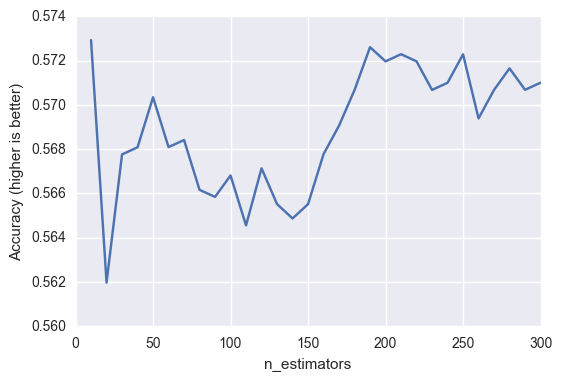

In [327]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, rfscores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (higher is better)')

In [333]:
sorted(zip(rfscores,estimator_range))

[(0.56197513103674734, 20),
 (0.56455887955709827, 110),
 (0.56487264452458386, 140),
 (0.5655178091554437, 150),
 (0.56552039974204371, 130),
 (0.56584609376787709, 90),
 (0.56616400601229877, 80),
 (0.56681279512602256, 100),
 (0.56713537744145248, 120),
 (0.56776343017049602, 30),
 (0.56777483309423438, 160),
 (0.56808496355724447, 40),
 (0.56809378257545728, 60),
 (0.56841584209681506, 70),
 (0.56906360232508069, 170),
 (0.56938929802118277, 260),
 (0.57034510588751297, 50),
 (0.5706728743869488, 180),
 (0.57067598943788955, 230),
 (0.57067806558176049, 270),
 (0.57068273398249991, 290),
 (0.5709996056495833, 240),
 (0.57100168346372282, 300),
 (0.57164943701091409, 280),
 (0.57196682312072655, 200),
 (0.57196682813153232, 220),
 (0.57228474037595412, 250),
 (0.57228992655995992, 210),
 (0.57260731768057815, 190),
 (0.57292731107967665, 10)]

In [338]:
#10 estimators had the highest accuracy

feature_range = range(1, len(test_columns)+1)
rf2_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rcl = RandomForestClassifier(n_estimators=10, max_features=feature, random_state=1)
    acc_scores = cross_val_score(rcl, Xrf, yrf, cv=10, scoring='accuracy')
    rf2_scores.append(np.mean(acc_scores))

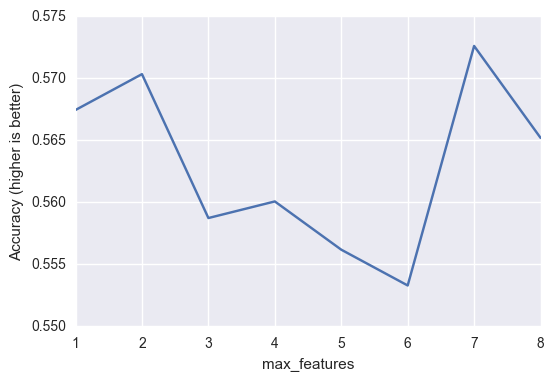

In [339]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, rf2_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy (higher is better)')

In [340]:
sorted(zip(rf2_scores,feature_range))

[(0.55329550943600159, 6),
 (0.55618211931311434, 5),
 (0.55873368156293113, 3),
 (0.56007187144708637, 4),
 (0.56520096043428336, 8),
 (0.56744859887434629, 1),
 (0.57033941812022471, 2),
 (0.57261102042282341, 7)]

In [342]:
rcl = RandomForestClassifier(n_estimators=10, max_features=7, oob_score=True, random_state=1)
rcl.fit(Xrf, yrf)

/Users/jennawhite/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [345]:
pd.DataFrame({'feature':test_columns, 'importance':rcl.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,years_of_experience,0.253197
0,days_til_start,0.245702
3,ratings_count,0.212870
4,testimonial_count,0.141371
2,ratings_average,0.085378
7,svc_drop-in,0.031019
5,calls_duration,0.020062
6,voice_calls,0.010401


In [347]:
rcl.oob_score_

0.5552334943639291

The Random Forest shows that years of experience and testimonials may have more predictive usefulness for OOB samples, than the decision tree showed

### Combining TDIDF features with DT features

In [355]:
final_columns = [
                'days_til_start',
                'years_of_experience',
                'ratings_average',
                'ratings_count',
                'testimonial_count',
               ]